# Import Libraries

In [1]:
# Math
import math

# Numpy
import numpy as np

# Scipy
from scipy.stats import boxcox

# Pandas 
import pandas as pd

# Matplotlib
import matplotlib.pyplot as plt

# Statsmodel
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Sklearn
from sklearn.metrics import mean_squared_error

# Supress all warnings
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
#Load Dataset
data = pd.read_csv('Data/water.csv', parse_dates=[0], index_col=['Year'], header=0)

# Check if there is any missing values in the dataset
print('Number of misisng values in the dataset : %s '% (np.sum(data.isna())[0]))

Number of misisng values in the dataset : 0 


In [3]:
# split data into training set and validation set
# Training_data consists of data from 1885 to 1953
# Validaion_data consists of data from 1954 to 1963
train_data, validation_data = data[0:len(data)-10].values, data[len(data)-10:].values

# Data Analysis

### Summary Statistics

In [4]:
data.describe()

,Water
count,79.000000
mean,512.025316
std,75.685072
min,344.000000
25%,462.000000
50%,503.000000
75%,581.000000
max,662.000000


### Line plot

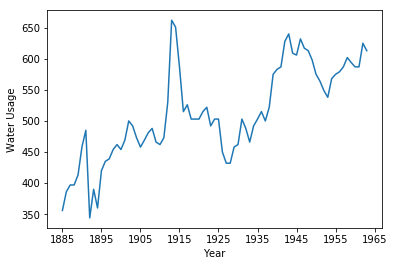

In [5]:
plt.plot(data)
plt.xlabel('Year')
plt.ylabel('Water Usage')
plt.show()

#### Analysis (Line Plot):
1- There are low fluctations towards the starting and somewhat at end of the data. <br>
2- But in the middle between the years 1910-1920 the fluctuation is high, seems like people in baltimore during the years 1910-1920 consumed a lot of water. I assume that the population during this time increased or might be something else.

### Density plot

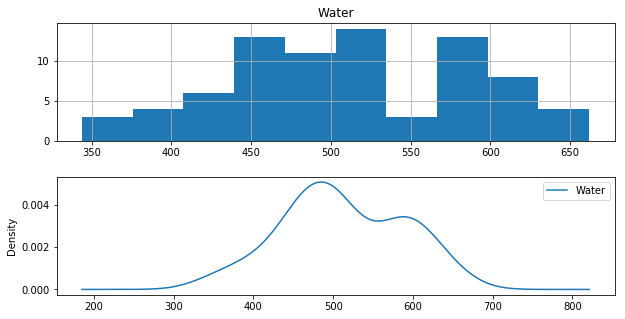

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(211)
data.hist(ax=plt.gca())
plt.subplot(212)
data.plot(kind='kde', ax=plt.gca())
plt.show()

#### Analysis (Density Plot):
1- The fist plot suggest that the data is close to gaussian but not perfect gaussian. <br>
2- The second plot suggest that the data is exponential distributed and will require power transform to be applied to it.

### Box and Whisker plot

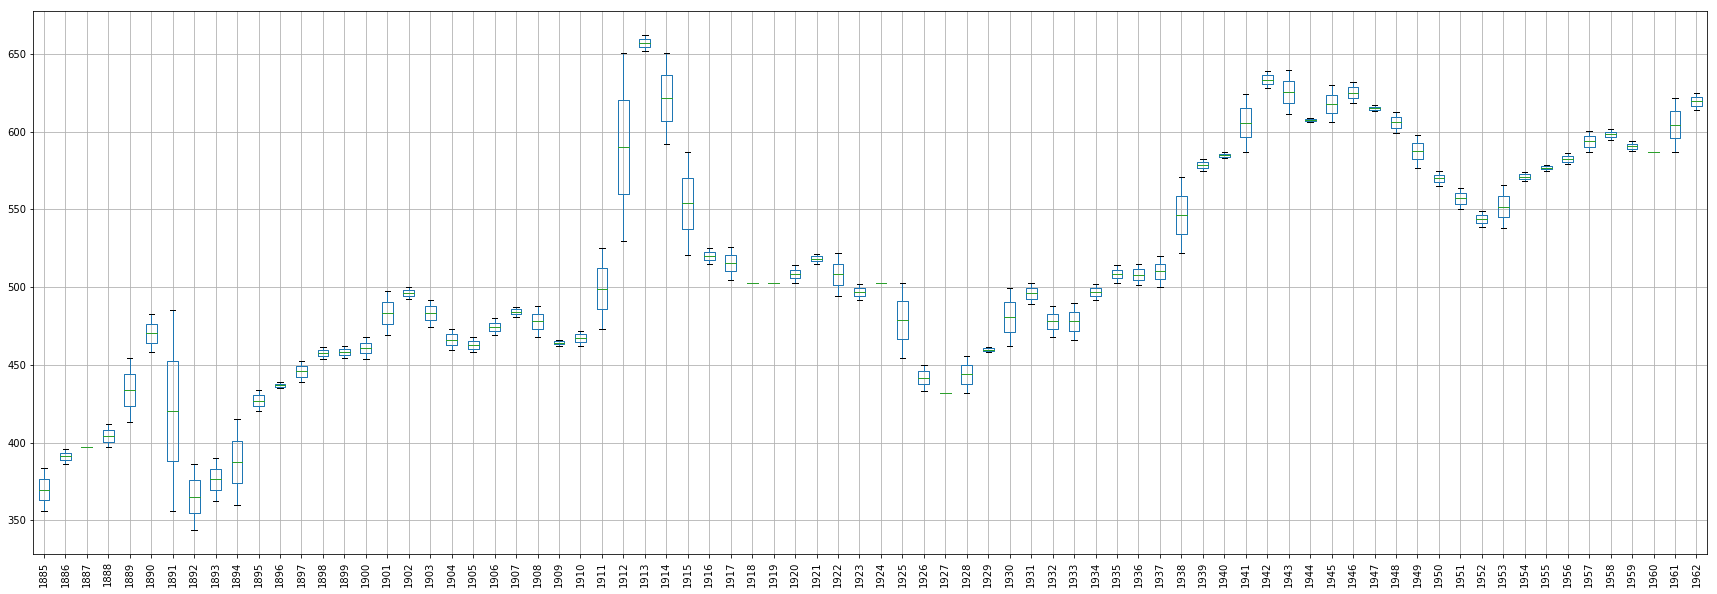

In [7]:
# Upsampling the data to monthly level
data_updamples = data.resample('M').mean().interpolate(method='linear')

# Group the data year-wise
data_up_year = data_updamples.groupby(pd.TimeGrouper('Y'))

# Create data frame for Boxplot
box_df = pd.DataFrame()
for date, yr_gp in data_up_year:
    
    """
    Had to exclude 1963 for boxplot because while grouping there was only one value present for this year
    """
    
    if date.year == 1963:  break

    box_df[date.year] = np.concatenate(yr_gp.values)

# Plot Boxplot
plt.figure(figsize=(30, 10))
box_df.boxplot()
plt.xticks(rotation='vertical')
plt.show()

#### Analysis (Box Whisker Plot):
1- The trend, which can be observed from the 50-percentile (median) of each year seems to be almost similar to original when upsampling. <br>
2- Let's further visualize it using the heat map, which might give us more insight about the data.

###  Heatmap

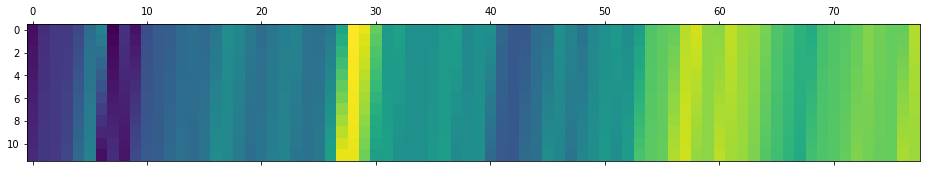

In [8]:
plt.matshow(box_df)
plt.show()

#### Analysis (Heat Map): 
Note: 
    * Warmer colors : Large values
    * Cooler colors : Small Values    

1- It can be observed that, during the initial years the water usage was less due less consumption ( assuming less population) but between 1910-1918 (first yellow bar) there is a surge observed seems like more people started moving in at baltimore due to some attractive economy hence water comsumption started increasing but there are some low values after that and waster usage kind of shows a mixture of upward and downward trend during the following by years.

### Stationarity test

In [9]:
adf_result = adfuller(np.concatenate(data.values.astype('float32')))

In [10]:
print('p-value %.2f' % (adf_result[1]) )

p-value 0.25


#### Analysis (ADF test):
Following observation can be made from above p-value : <br>
1- Given p-value of 0.25 seems like null hypothesis is accepted meaning that the data is not stationary and ARIMA model assumes data to be stationary, lets first make it stationary and then do ADF test

In [11]:
adf_data = data.values
adf_post_diff = adfuller(np.concatenate([adf_data[i] - adf_data[i-1] for i in range(1,len(adf_data))]))

In [12]:
print('p-value after differencing : %.10f' % (adf_post_diff[1]))

p-value after differencing : 0.0000000041


#### Analysis (Post differencing):
Following observation can be made from above p-value : <br>
1- Given p-value of 0.0000000041 seems like null hypothesis is rejected meaning that the data is stationary and we can model ARIMA on it, suggesting 1-level differencing is required.

### Find AR-MA parameters of ARIMA model using ACF and PACF plot

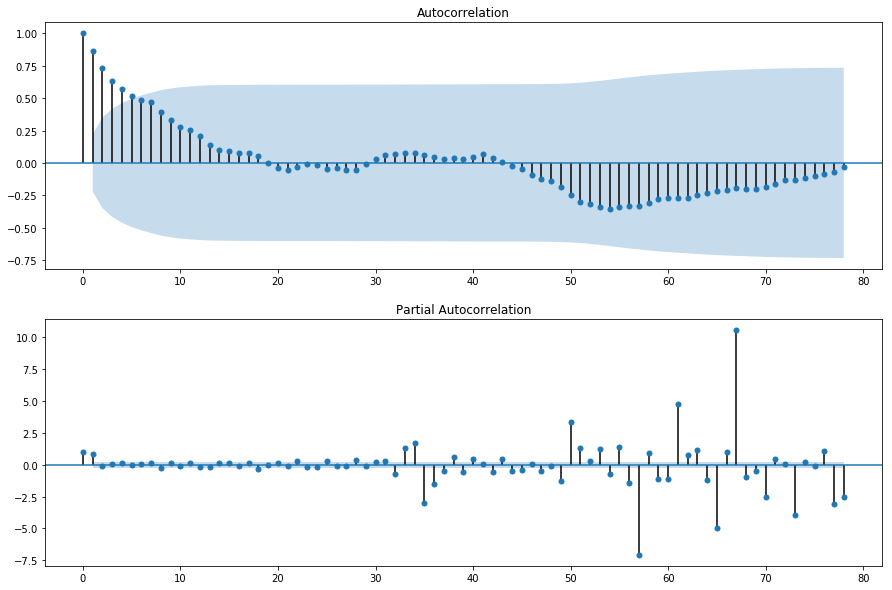

In [13]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plot_acf(data, ax=plt.gca())
plt.subplot(212)
plot_pacf(data, ax=plt.gca())
plt.show()

### Analysis (ACF And PACF):

Following observations can be made from above plots : <br>

1- From ACF plot it can be observed that lag uptill 5 shows great correlation so will consider value of p=5 hence its an AR(5) process. <br>
2- From PACF plot it can be observed that lag values uptill 1 so will consider value of q=1 hence its an MA(1) process. <br>
3- Since, from the previous differencing part we found that d=1 makes the time series stationary, hence will take value of d=1.  <br>

# ARIMA Model

## Persistence Model With Walk Forward Validation (Baseline RMSE)

In [14]:
def persistence_model(ps_tr_data, ps_val_data):
    
    history = [i for i in ps_tr_data]
    predictions = []
    
    for i in range(len(ps_val_data)):
        
        # Get predictions
        y_pred = history[-1]
        predictions.append(y_pred)
        
        #  Get actual
        history.append(ps_val_data[i])
        
        print('Predicted : %.2f  Actual: %.2f' % (y_pred, ps_val_data[i]))
        
    print('Baseline RMSE : %.2f' % (math.sqrt(mean_squared_error(ps_val_data, predictions))))

# Persistence model
persistence_model(train_data, validation_data)

Predicted : 538.00  Actual: 568.00
Predicted : 568.00  Actual: 575.00
Predicted : 575.00  Actual: 579.00
Predicted : 579.00  Actual: 587.00
Predicted : 587.00  Actual: 602.00
Predicted : 602.00  Actual: 594.00
Predicted : 594.00  Actual: 587.00
Predicted : 587.00  Actual: 587.00
Predicted : 587.00  Actual: 625.00
Predicted : 625.00  Actual: 613.00
Baseline RMSE : 17.19


### Analysis (Persistance Model):
Got RMSE value of 17.19 which will act as a baseline value for improvement of ARIMA model.

## ARIMA(5,1,1)

In [15]:
def arima_obs(tr_ao, vl_ao, order):
    
    history = [i for i in tr_ao]
    predictions = []
    
    for i in range(len(vl_ao)):
        
        # get predictions
        fitted_model = ARIMA(history, order=order).fit(disp=0)
        y_pred = fitted_model.forecast()[0]
        predictions.append(y_pred)
        
        # append history values
        history.append(vl_ao[i])
        
        print('Predictde: %.2f Actual: %.2f' % (y_pred, vl_ao[i]))
        
    print('\nRMSE: %.2f with ARIMA%s' % (math.sqrt(mean_squared_error(vl_ao, predictions)), order))
    
    
    # RESIDUAL ANALYSIS
    print('\n\n-------------------------------------------------------------------------------------RESIDUAL ANALYSIS-------------------------------------------------------------------------------------')
    rsd = pd.DataFrame([vl_ao[i] - predictions[i] for i in range(len(vl_ao))])
    
    # plot residuals
    plt.figure(figsize=(20,15))
    plt.subplot(511)
    rsd.hist(ax=plt.gca())
    plt.title('Histogram')
    plt.subplot(512)
    rsd.plot(kind='kde', ax=plt.gca())
    plt.title('Density Plot')
    plt.subplot(513)
    rsd.plot(kind='line', ax=plt.gca())
    plt.title('Line plot')
    plt.subplot(514)
    plot_acf(rsd, ax=plt.gca())
    plt.subplot(515)
    plot_pacf(rsd, ax=plt.gca())
    plt.tight_layout()
    plt.show()

Predictde: 550.20 Actual: 568.00
Predictde: 581.88 Actual: 575.00
Predictde: 584.41 Actual: 579.00
Predictde: 582.43 Actual: 587.00
Predictde: 594.56 Actual: 602.00
Predictde: 607.36 Actual: 594.00
Predictde: 597.57 Actual: 587.00
Predictde: 591.47 Actual: 587.00
Predictde: 595.82 Actual: 625.00
Predictde: 630.96 Actual: 613.00

RMSE: 13.98 with ARIMA(5, 1, 1)


-------------------------------------------------------------------------------------RESIDUAL ANALYSIS-------------------------------------------------------------------------------------


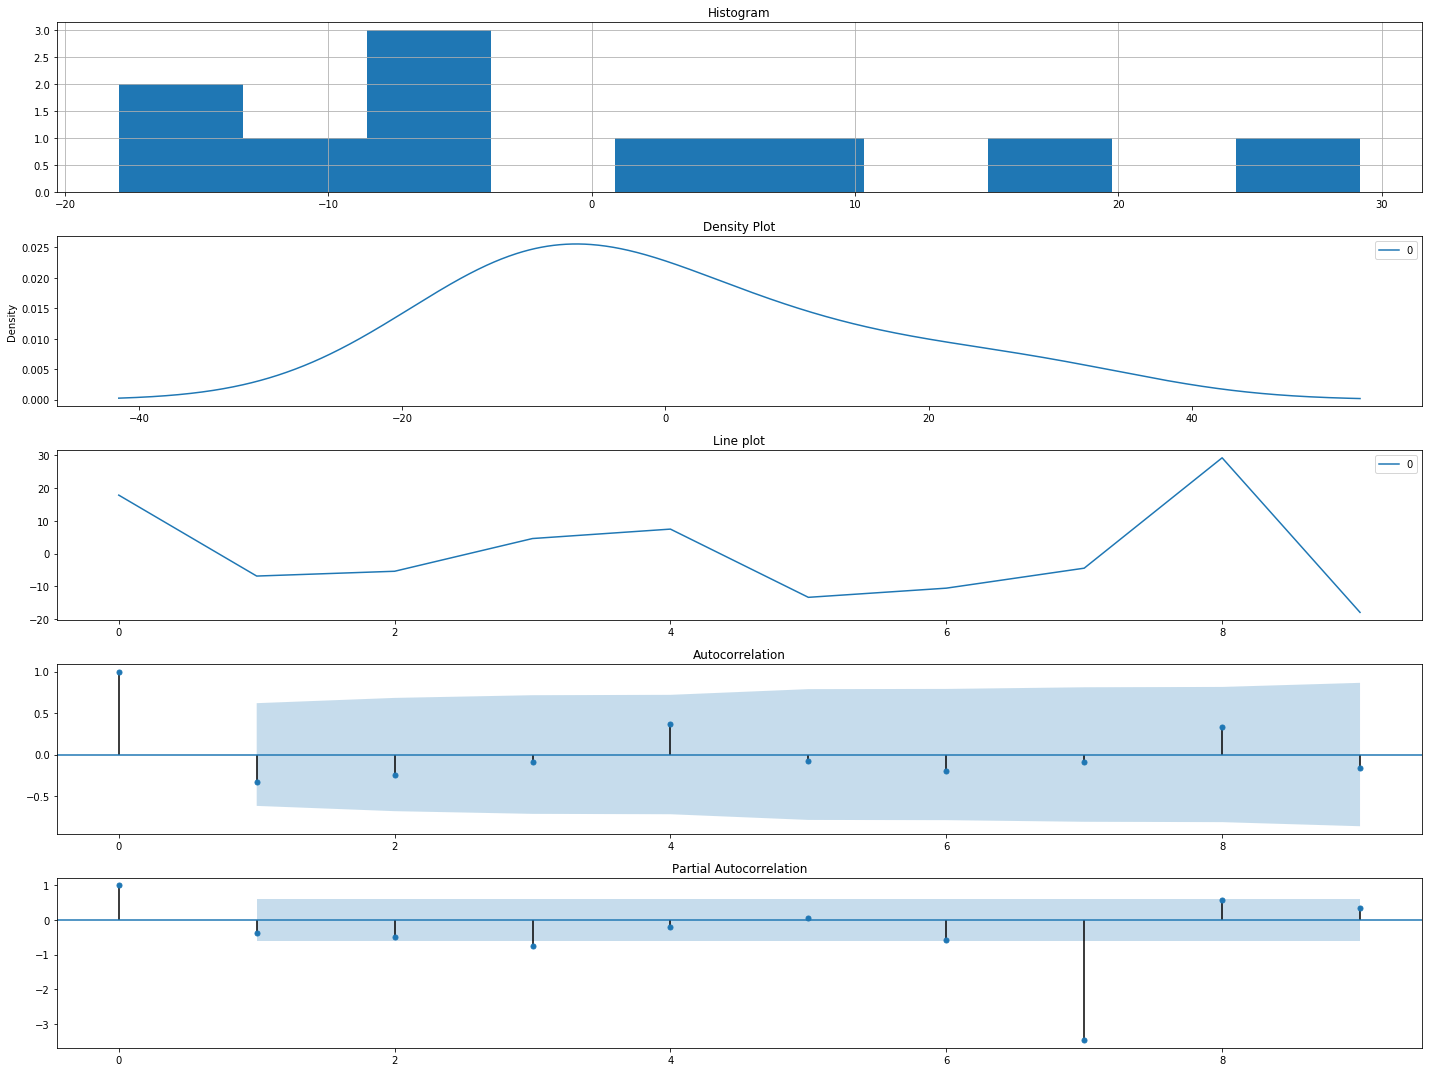

In [16]:
# ARIMA(6,1,2) performance
arima_obs(train_data, validation_data, (5,1,1))

### Analysis (ARIMA(5,1,1)):
Following observation can be made from the above ARIMA(5,1,1) <br>
1- RMSE value of 13.98 seems better performance as compared to persistence model <br>
2- ACF and PACF show that majority of the correlation is captured by the model. <br>
3- Observing histogram and density plots suggest applying power transform on the data to better expose the signal by removing the noise, before modelling ARIMA on the data. <br>
4- Lets apply GRID search on ARIMA with power transformed dataset with walk-forward validation model.

## ARIMA GRID search with power transform

In [17]:
def inverse_boxcox(x_val, lm_val):
    
    if lm_val == 0:
        return np.exp(x_val)
    
    return np.exp(np.log(lm_val * x_val + 1) / lm_val)

In [35]:
def evaluate_arima_model_power_transform(train, test, order):
    
    eval_history = [i for i in train]
    
    eval_predictions = []
    
    for i in range(len(test)):
        
        # Box transform
        train_hist, lmb = boxcox(eval_history)
        
        if lmb < -5:
            train_hist, lmb = eval_history, 1
        
        # Fit model and predict
        model = ARIMA(train_hist, order=order)
        eval_predictions.append(inverse_boxcox(model.fit(disp=0).forecast()[0], lmb))
        
        # Get y_true
        eval_history.append(test[i])
    
    # Evaluate performance
    rmse = np.sqrt(mean_squared_error(test, eval_predictions))
    return rmse

In [36]:
def grid_ARIMA_power_transform(p_values, d_values, q_values):
    
    
    best_rmse, best_cfg = float('inf'), None
    
    
    for i in p_values:
        for j in d_values:
            for k in q_values:                    
                
                try:
                    
                    grid_rmse = evaluate_arima_model_power_transform(train_data, validation_data, (i,j,k))
                    
                    if grid_rmse < best_rmse:
                        best_rmse, best_cfg = grid_rmse, (i,j,k)
                        
                    print('Got RMSE: %.2f ARIMA CFG : p:%s, d:%s and q:%s' % (grid_rmse, i,j,k))
                
                except:
                    continue
                

    print('Best RMSE: %.2f with ARIMA(p:%s, d:%s, q:%s)' % (best_rmse, best_cfg[0], best_cfg[1], best_cfg[2]))

In [20]:
# Define parameters p, d and q
p = np.arange(0, 13)
d = np.arange(0, 4)
q = np.arange(0, 13)

grid_ARIMA_power_transform(p,d,q)

Got RMSE: 89.11 ARIMA CFG : p:0, d:0 and q:0
Got RMSE: 54.25 ARIMA CFG : p:0, d:0 and q:1
Got RMSE: 39.73 ARIMA CFG : p:0, d:0 and q:2
Got RMSE: 32.00 ARIMA CFG : p:0, d:0 and q:4
Got RMSE: 29.09 ARIMA CFG : p:0, d:0 and q:5
Got RMSE: 29.51 ARIMA CFG : p:0, d:0 and q:6
Got RMSE: 16.14 ARIMA CFG : p:0, d:1 and q:0
Got RMSE: 16.23 ARIMA CFG : p:0, d:1 and q:1
Got RMSE: 15.23 ARIMA CFG : p:0, d:1 and q:2
Got RMSE: 13.93 ARIMA CFG : p:0, d:1 and q:3
Got RMSE: 14.12 ARIMA CFG : p:0, d:1 and q:4
Got RMSE: 14.25 ARIMA CFG : p:0, d:1 and q:5
Got RMSE: 14.22 ARIMA CFG : p:0, d:1 and q:6
Got RMSE: 14.47 ARIMA CFG : p:0, d:1 and q:7
Got RMSE: 21.39 ARIMA CFG : p:0, d:1 and q:8
Got RMSE: 21.25 ARIMA CFG : p:0, d:1 and q:9
Got RMSE: 15.48 ARIMA CFG : p:0, d:1 and q:11
Got RMSE: 20.60 ARIMA CFG : p:0, d:1 and q:12
Got RMSE: 26.38 ARIMA CFG : p:0, d:2 and q:0
Got RMSE: 17.87 ARIMA CFG : p:0, d:2 and q:1
Got RMSE: 18.00 ARIMA CFG : p:0, d:2 and q:2
Got RMSE: 21.39 ARIMA CFG : p:1, d:0 and q:0
Got RMSE

### Analysis (Grid Search Arima):
Following observation can be made from the above ARIMA(5,1,1) <br>
1- ARIMA(12,1,1) turns out to give the best RMSE, much better than persistence model and ARIMA(5,1,1).
2- Let's analyze the residuals of ARIMA(12,1,1)

## ARIMA(12,1,1)

In [39]:
history = [i for i in train_data]
prediction = list()

# walk forward validation model
for i in range(len(validation_data)):
    
    # remove noise
    x_train , lm_val = boxcox(history)
    
    if lm_val < -5 :
        x_train , lm_val = history, 1
        
    # Fit model and get predictions
    model_fitted = ARIMA(x_train, order=(12,1,1)).fit(disp=0)
    y_pred = inverse_boxcox(model_fitted.forecast()[0], lm_val)    
    prediction.append(y_pred)
    
    # Append history
    history.append(validation_data[i])
    
    print('Predicted: %.2f Actual: %.2f' % (y_pred, validation_data[i]))
    
print('RMSE: %.2f' % (math.sqrt(mean_squared_error(validation_data, prediction))))

Predicted: 557.76 Actual: 568.00
Predicted: 573.96 Actual: 575.00
Predicted: 576.55 Actual: 579.00
Predicted: 585.39 Actual: 587.00
Predicted: 590.34 Actual: 602.00
Predicted: 599.96 Actual: 594.00
Predicted: 592.38 Actual: 587.00
Predicted: 583.13 Actual: 587.00
Predicted: 588.63 Actual: 625.00
Predicted: 627.11 Actual: 613.00
RMSE: 13.61


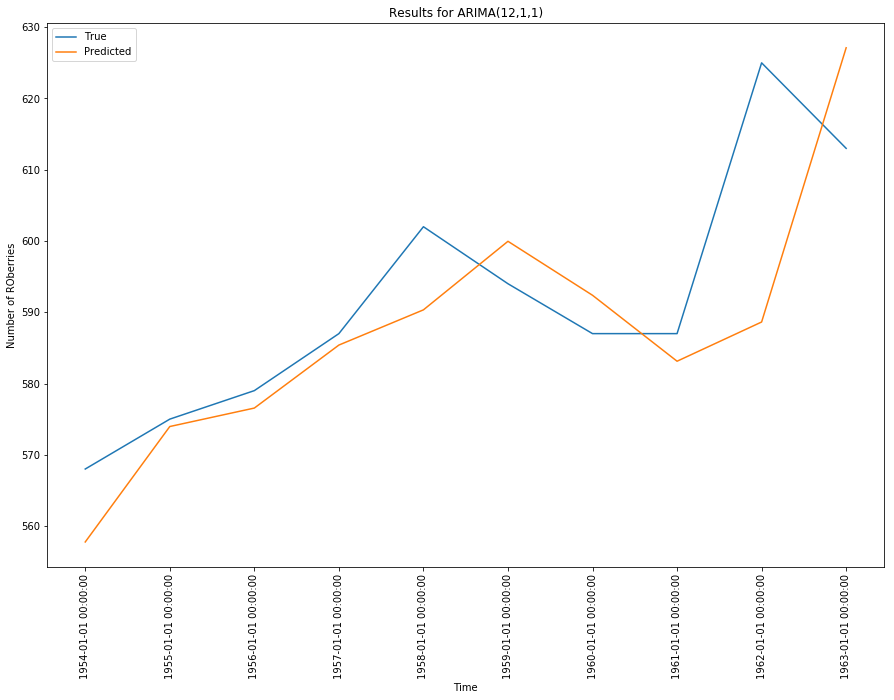

In [48]:
plt.figure(figsize=(15,10))
plt.plot(validation_data, label='True')
plt.plot(prediction, label='Predicted')
plt.xticks(np.linspace(0,9, 10), data[len(data)-10:].index, rotation=90 )
plt.ylabel('Number of ROberries')
plt.xlabel('Time')
plt.legend()
plt.title('Results for ARIMA(12,1,1)')
plt.savefig(fname='Results.jpg', dpi=300)
plt.show()

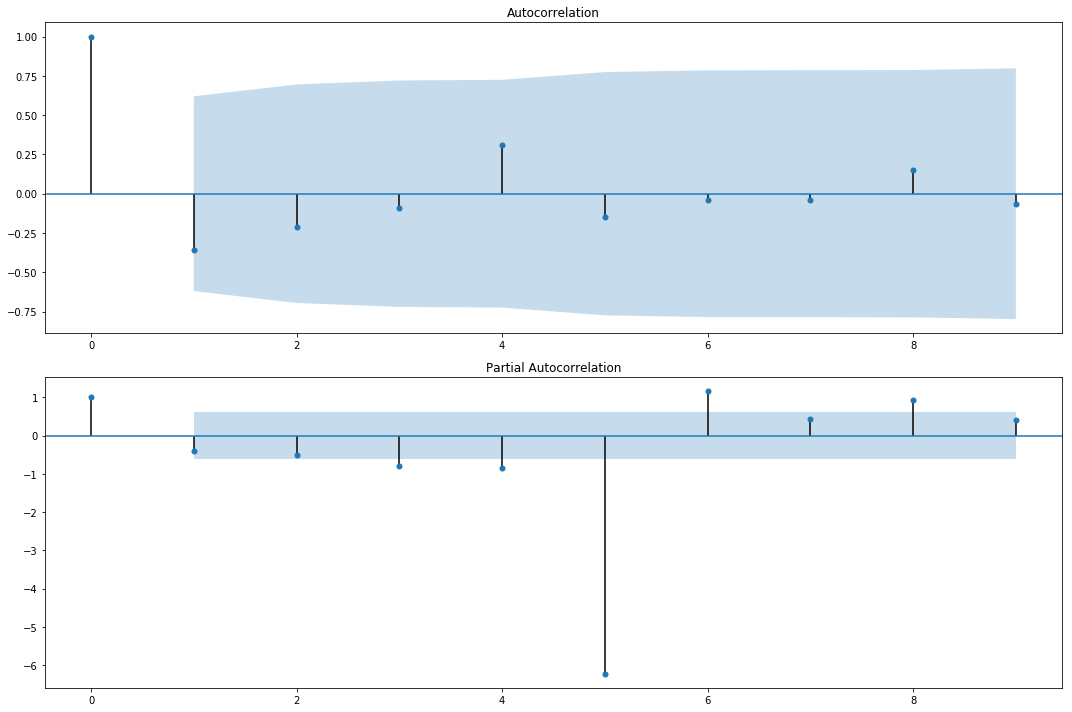

In [49]:
# compute residuals
final_arima_rsd = [validation_data[i] - prediction[i] for i in range(len(validation_data))]

# plot residuals
plt.figure(figsize=(15,10))
plt.subplot(211)
plot_acf(final_arima_rsd, ax=plt.gca())
plt.subplot(212)
plot_pacf(final_arima_rsd, ax=plt.gca())
plt.tight_layout()
plt.show()

### Analysis (ACF and PACF of residuals of ARIMA on power transformed dataset):
1- It can be observed that majority of the autocorrelation in captured by the model.

### Hence, best ARIMA configuration that can capture the latent structure for this data turns out to be ARIMA(10,1,2).